In [33]:
### Not to be included in the paper ###
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import sys
import cuqi
cuqi.__version__

'0+untagged.2405.gd4b304b.dirty'

** Not to be included in the paper **
$\newcommand{\code}[1]{\texttt{#1}}$

# CUQIpy example: 1D Heat problem

Here we go through the steps of creating a time dependant PDE-based Bayesian problem within the CUQIpy library. The problem we consider is a one dimensional (1D) initial-boundary value heat equation with zero boundary conditions.

\begin{align}
\frac{\partial u(x,t)}{\partial t} - c^2 \frac{\partial^2 u(x,t)}{\partial x^2}   & = f(x,t), \;x\in[0,L],\; 0\le t \le T\\
u(0,t)= u(L,t)&= 0\\
u(x,0)&= g(x) 
\end{align}


where $u(x,t)$ is the temperature and $c^2$ is the thermal diffusivity (assumed to be 1 here). We assume the source term $f$ is zero. The unknown Bayesian parameters (random variable) for this test problem is the initial heat profile $g(x)$.

The data we obtain for this problem is the measurement of the temperature profile in the domain at time $T$. We assume that the measurement error $\eta$ follows a Gaussian distribution. In a Bayesian setting, we can represent the data as a random variable $y$:

\begin{align}
y = \mathcal{G}(\theta) + \eta, \;\;\; \eta\sim\mathcal{N}(0,\sigma_\text{noise}^2\mathbf{I}),
\end{align}

where $\mathcal{G}(\theta)$ is the forward model that maps the initial condition $\theta$ to the final time solution $u(x,T)$ via solving the 1D time-dependent heat problem. For this test case, $T=0.01$, $L=1$, relative noise level is $1\%$, and the number of grid nodes for the finite difference discretization is $100$.

In the remaining of this section, we create and solve the inverse heat equation in a Bayesian setting, i.e. constructing the posterior distribution for $\theta(x)$ given some observed data $y_\text{obs}$.

### 1. Create the PDE problem

In [34]:
### Not to be included in the paper ###
""" Case1
# Prepare PDE form
N = 100   # Number of solution nodes
L = 1.0  # Length of the domain
T = 0.01 # Final time
dx = L/(N+1)   # Space step size
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*dx**2 # Defining approximate time step size
num_time_steps = int(T/dt_approx)+1 # Number of time steps
Ns = 1000 # Number of samples
"""

"""
case_name = 'case2_temp'
# Very Good results, min ESS ~60, I will use this case for the paper
# unless we decide to increase the final time. Can display 50% CI
# Prepare PDE form
N = 100   # Number of solution nodes
L = 1.0  # Length of the domain
T = 0.01 # Final time
dx = L/(N+1)   # Space step size
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*dx**2 # Defining approximate time step size
num_time_steps = int(T/dt_approx)+1 # Number of time steps
Ns = 1000 # Number of samples
domain_dim = 20
scale = np.ones(domain_dim)
scale[0] = 0.05
scale[1] = 0.1
scale[2] = 0.2
"""

"""
case_name = 'case3'
# Here we increased the final time to 0.04, the results 
# are not as good as case2 but still acceptable. Min ESS ~ 25
# Prepare PDE form
N = 100   # Number of solution nodes
L = 1.0  # Length of the domain
T = 0.04 # Final time
dx = L/(N+1)   # Space step size
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*dx**2 # Defining approximate time step size
num_time_steps = int(T/dt_approx)+1 # Number of time steps
Ns = 1000 # Number of samples
domain_dim = 20
scale = np.ones(domain_dim)
scale[0] = 0.05
scale[1] = 0.1
scale[2] = 0.2
"""
"""
case_name = 'case4'
# Here we set the final time to 0.02, the results
# did not look very good 
# Min ESS ~ 55
# Prepare PDE form
N = 100   # Number of solution nodes
L = 1.0  # Length of the domain
T = 0.02 # Final time
dx = L/(N+1)   # Space step size
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*dx**2 # Defining approximate time step size
num_time_steps = int(T/dt_approx)+1 # Number of time steps
Ns = 1000 # Number of samples
domain_dim = 20
scale = np.ones(domain_dim)
scale[0] = 0.05
scale[1] = 0.1
scale[2] = 0.2
"""

case_name = 'case5'
# 
# Prepare PDE form
N = 100   # Number of solution nodes
L = 1.0  # Length of the domain
T = 0.02 # Final time
dx = L/(N+1)   # Space step size
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*dx**2 # Defining approximate time step size
num_time_steps = int(T/dt_approx)+1 # Number of time steps
Ns = 3000 # Number of samples
domain_dim = 20
scale = np.ones(domain_dim)
scale[0] = 0.05
scale[1] = 0.1
scale[2] = 0.2



Here we set the physical and numerical parameters and create the components that we need to define the 1D time-dependant heat problem. We discretize the heat problem on a grid of  $\code{N=80}$ nodes. We choose the domain length $\code{L=1}$, and the time $\code{T=0.04}$. We discretize the time interval $[0,T]$ into $\code{num\_time\_steps=434}$ time steps. In the following, we define three python objects: a $\code{numpy.ndarray}$ representing the spatial grid $\code{grid}$, a $\code{numpy.ndarray}$ array representing the time steps $\code{time\_steps}$ and a $\code{numpy.ndarray}$ representing the discretized diffusion differential operator using centered difference.

In [35]:
# Grid for the heat model
grid = np.linspace(dx, L, N, endpoint=False)

# Time steps
time_steps = np.linspace(0, T, num_time_steps, endpoint=True)

# FD diffusion operator
Dxx = (np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1), -1)
       + np.diag(np.ones(N-1), 1))/dx**2  

### 2. Create $\code{cuqi.pde.TimeDependentLinearPDE}$ object

The details of the PDE problem is encapsulated in a $\code{cuqi.pde.PDE}$ object. For this time-dependent problem we create $\code{cuqi.pde.TimeDependentLinearPDE}$ object. This object needs information about the grid $\code{grid}$, the time steps $\code{time\_steps}$, and a representation of the PDE $\code{PDE\_form}$ at a given time $\code{t}$. As an optional argument, one can also specify whether the time discretization scheme is implicit or explicit Euler. the user can also provide advanced arguments such as the linear solver to be used.

This representation $\code{PDE\_form}$ is a python function that accepts as the first argument an instance of the inverse problem parameter, the $\code{initial\_condition}$ here, and the time $\code{t}$ as a second argument. It returns a tuple of the differential operator at time $\code{t}$, the right hand side at time $\code{t}$ and the initial condition. 

In [36]:
# PDE form (diff_op, IC, time_steps)
def PDE_form(initial_condition, t): return (Dxx, np.zeros(N),
                                            initial_condition)

PDE = cuqi.pde.TimeDependentLinearPDE(
    PDE_form, time_steps, grid_sol=grid)

### 3. Create the forward model

Next we create a $\code{cuqipy}$ forward model. We create a $\code{cuqi.model.PDEModel}$ which is a subclass of $\code{cuqi.model.Model}$. To initialize an object of this class, we pass a $\code{cuqi.pde.PDE}$ along with two $\code{cuqi.geometry.Geometry}$ objects to represent the domain and the range of the forward PDE problem. $\code{cuqi.model.PDEModel}$ is agnostic to the underlying details of the PDE. It interact with the $\code{PDE}$ object through the functions $\code{assemble}$, $\code{solve}$, and $\code{observe}$. 

The domain geometry represents the domain of the forward problem. For the heat equation the domain geometry represents the function space of the discretized $g(x)$. To impose some regularity on the initial condition $g(x)$, we parametrize it using Karhunen–Loève (KL) expansion  

$$g(x_j) = u(x_j,0) = \sum_{i=0}^{N-2} \left(\frac{1}{(i+1)^\gamma\tau}\right)  \theta_i \, \text{sin}\left(\frac{\pi}{N}(i+1)(j+\frac{1}{2})\right) + \frac{(-1)^j}{2}\left(\frac{1}{N^\gamma\tau}\right)  \theta_{N-1},$$

    
where $x_j$ is the $j^\text{th}$ grid point (in a regular grid), $j=0, 1, 2, 3, ..., N-1$, $\gamma$ is the decay rate, $\tau$ is a normalization constant, and $\theta_i$ are the expansion coefficients. We note that using the KL-expansion parameterization, the Bayesian parameters becomes the coefficients of expansion $\theta_i$. We set up the domain geometry as a $\code{cuqi.geometry.KLExpansion}$ object and pass the arguments $\code{decay\_rate=1.7}$ and $\code{normalizer=12}$ for the decay rate and the normalization constants, respectively.

The range geometry represents the function space of the observed data, $u(0,T)$ in this case, which can be represented by a $\code{cuqi.geometry.Continuous1D}$ object.

In [37]:
# (paper) define what is domain dim

# Set up geometries for model
domain_geometry = cuqi.geometry.KLExpansion(grid, decay_rate=1.7,
                                            normalizer=12, 
                                            num_modes=domain_dim)
range_geometry = cuqi.geometry.Continuous1D(grid)

# Prepare model
model = cuqi.model.PDEModel(PDE, range_geometry, domain_geometry)

### 4. Create the Bayesian model

After constructing the forward model, we want to set up the Bayesian model, i.e. the posterior distribution. In $\code{CUQIpy}$ we achieve this by creating a joint distribution on the Bayesian parameters $\theta$ and the data $y$ using the $\code{JointDistribution}$ class, and then, condition it on a synthesized data that we create for this test case. The joint distribution is given by:

\begin{align}
p(\theta,y) = p(y|\theta)p(\theta)
\end{align}
where $p(x)$ is the prior probability density function (PDF) and $p(y|\theta)$ is the data distribution PDF.

We start by defining the prior distribution $p(\theta)$ as a standard multivariate Gaussian distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$ using $\code{cuqi.distribution.Gaussian}$ class. We pass the keyword argument $\code{geometry=domain\_geometry}$ when initializing this distribution so that the distribution encapsulates the knowledge that the multivariate random variable $\theta$ represents the expansion coefficient in the KL expansion (<equation-number>).

In [38]:
# Create the prior distribution
x = cuqi.distribution.Gaussian(np.zeros(model.domain_dim), 1,
                               geometry=domain_geometry)


Now samples from the prior will look like:

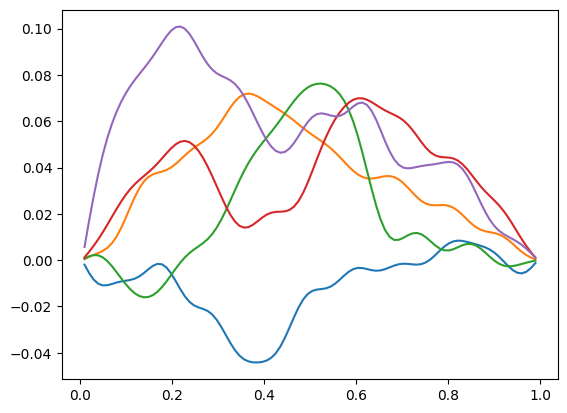

In [39]:
### Not to be included in the paper ###
for i in range(5):
    x.sample().plot()

For this test case, we assume that the true initial heat profile is given by the expression

\begin{align}
g_\text{exact}(x) = e^{-2x} \sin(L-x)
\end{align}

We create $\code{cuqi.samples.CUQIarray}$ object representing this signal and we call it $\code{theta\_true}$. We apply the forward model on $\code{theta\_exact}$ to obtain what we call exact data $\code{y\_exact}$, which is the outcome of the forward model that is not corrupted by measurement noise. 

In [40]:
### Not to be included in the paper ###

# True parameters that we want to infer
x_exact_raw = grid*np.exp(-2*grid)*np.sin(L-grid)
x_exact = cuqi.samples.CUQIarray(x_exact_raw, is_par=False,
                                 geometry=domain_geometry)


In [41]:
# Generate the exact data
y_exact = model.forward(x_exact)


We then create the data distribution $\code{y}$ as a $\code{cuqi.distribution.GaussianCov}$ object with the mean being the forward model applied to the Bayesian parameter $\theta$ $\code{model(x)}$ and covariance matrix given by $\sigma^2\mathbf{I}_M$ where $\sigma= \frac{0.01}{\sqrt{N}} ||\mathcal{G}(g_\text{exact}(x))||$ and $\mathbf{I}_M$ is the $M$ dimensional identity matrix. We also equip the data distribution with the range geometry $\code{range\_geometry}$.

In [42]:
### Not to be included in the paper ###
sigma =1.0/np.sqrt(N)* 0.01*np.linalg.norm(y_exact)

In [43]:
# Create the data distribution
y = cuqi.distribution.Gaussian(model(x),
                               sigma**2*np.eye(model.range_dim),
                               geometry=range_geometry)


An instance of a noisy data ($\code{data}$) can then be simply generated as a sample of the distribution $\code{y}$ conditioned on $\code{x=x\_exact}$. Figure <fig-num> shows the exact solution $g(x)$, and the exact and the noisy data.

In [44]:
# Generate noisy data
data = y(x = x_exact).sample()

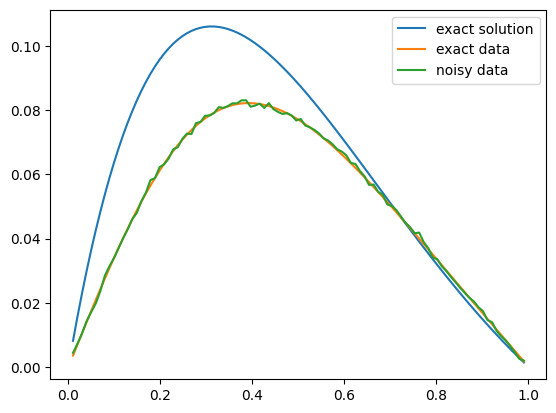

In [45]:
### Not to be included in the paper ###

x_exact.plot()
y_exact.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

In [46]:
### Not to be included in the paper ###

#plt.plot(data-y_exact)
print(np.linalg.norm(data-y_exact))
print(np.linalg.norm(y_exact))
print(np.linalg.norm(data-y_exact)/np.linalg.norm(y_exact))


0.006133897312495202
0.5679576280742489
0.010799920644244468


Now that we have the distributions $\code{x}$ and $\code{y}$, we can create the joint distribution $p(x,y)$. Conditioning the joint distribution on $\code{y=data}$ gives the posterior distribution. 

In [47]:
# Bayesian model
joint_distribution = cuqi.distribution.JointDistribution(x, y)
posterior = joint_distribution(y = data) 

### 5. Estimate the Bayesian solution

In $\code{CUQIpy}$ we use MCMC sampling methods to approximate the posterior and compute its moments. In this test case, we use a component wise Metropolis Hastings (CWMH) algorithm which is implemented in the class $\code{cuqi.sampler.CWMH}$. We create a sampler, which takes the $\code{posterior}$ as an argument in the initialization, and then generates 4000 samples. The $\code{CWMH}$ method $\code{sample\_adapt}$ adjusts the step size of the algorithm (the step size) to achieve a target acceptance rate of about $0.23$. 

In [48]:
# (paper) scale =
MySampler = cuqi.sampler.CWMH(posterior, scale = scale)
posterior_samples = MySampler.sample_adapt(Ns)

Sample 3000 / 3000

Average acceptance rate all components: 0.5947499999999999 



In [49]:
### Not to be included in the paper ###
MySampler.scale

array([0.02086188, 0.05780113, 0.20066289, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

CUQIpy provides post-processing methods and visualization methods that we can use to study the posterior samples. In figure <ci-fig1> we show a credible interval computed on the coefficient space then transformed to the function space. Furthermore, in Figure <ci-fig2> we transform the samples to the function space first, then compute the credible interval. The later case can be achieved by applying $\code{plot\_ci}$ on the $\code{Samples}$ property $\code{funvals}$. This property returns a $\code{Samples}$ object which contains the function values of the samples. 

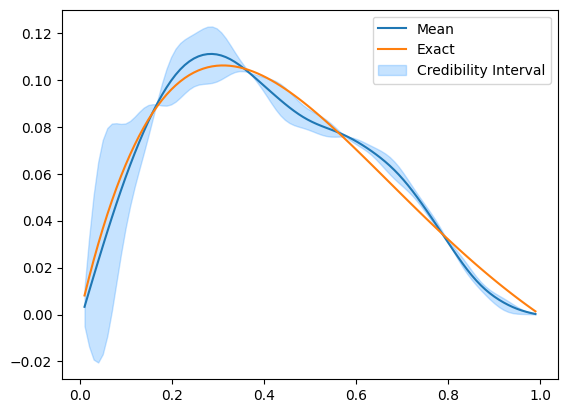

In [50]:
posterior_samples.plot_ci(95, exact=x_exact)

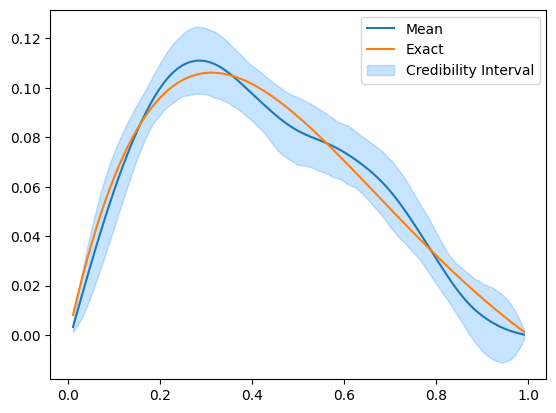

In [51]:
posterior_samples.funvals.plot_ci(95, exact=x_exact)

 None,
 <ErrorbarContainer object of 3 artists>]

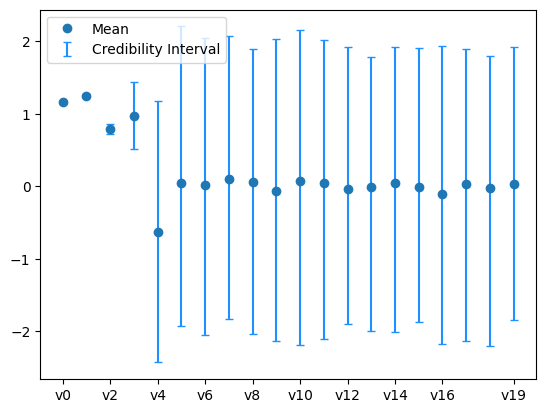

In [52]:
posterior_samples.plot_ci(95, plot_par=True)

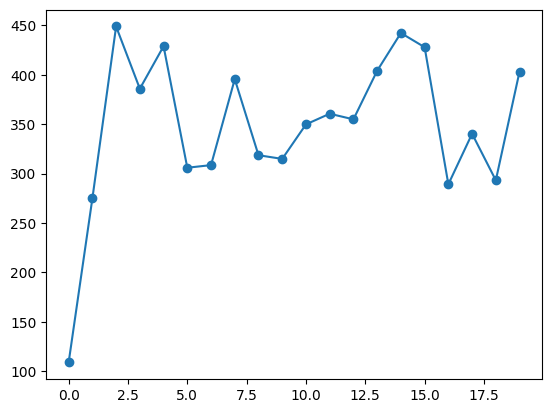

In [53]:
plt.plot(posterior_samples.compute_ess(), 'o-')

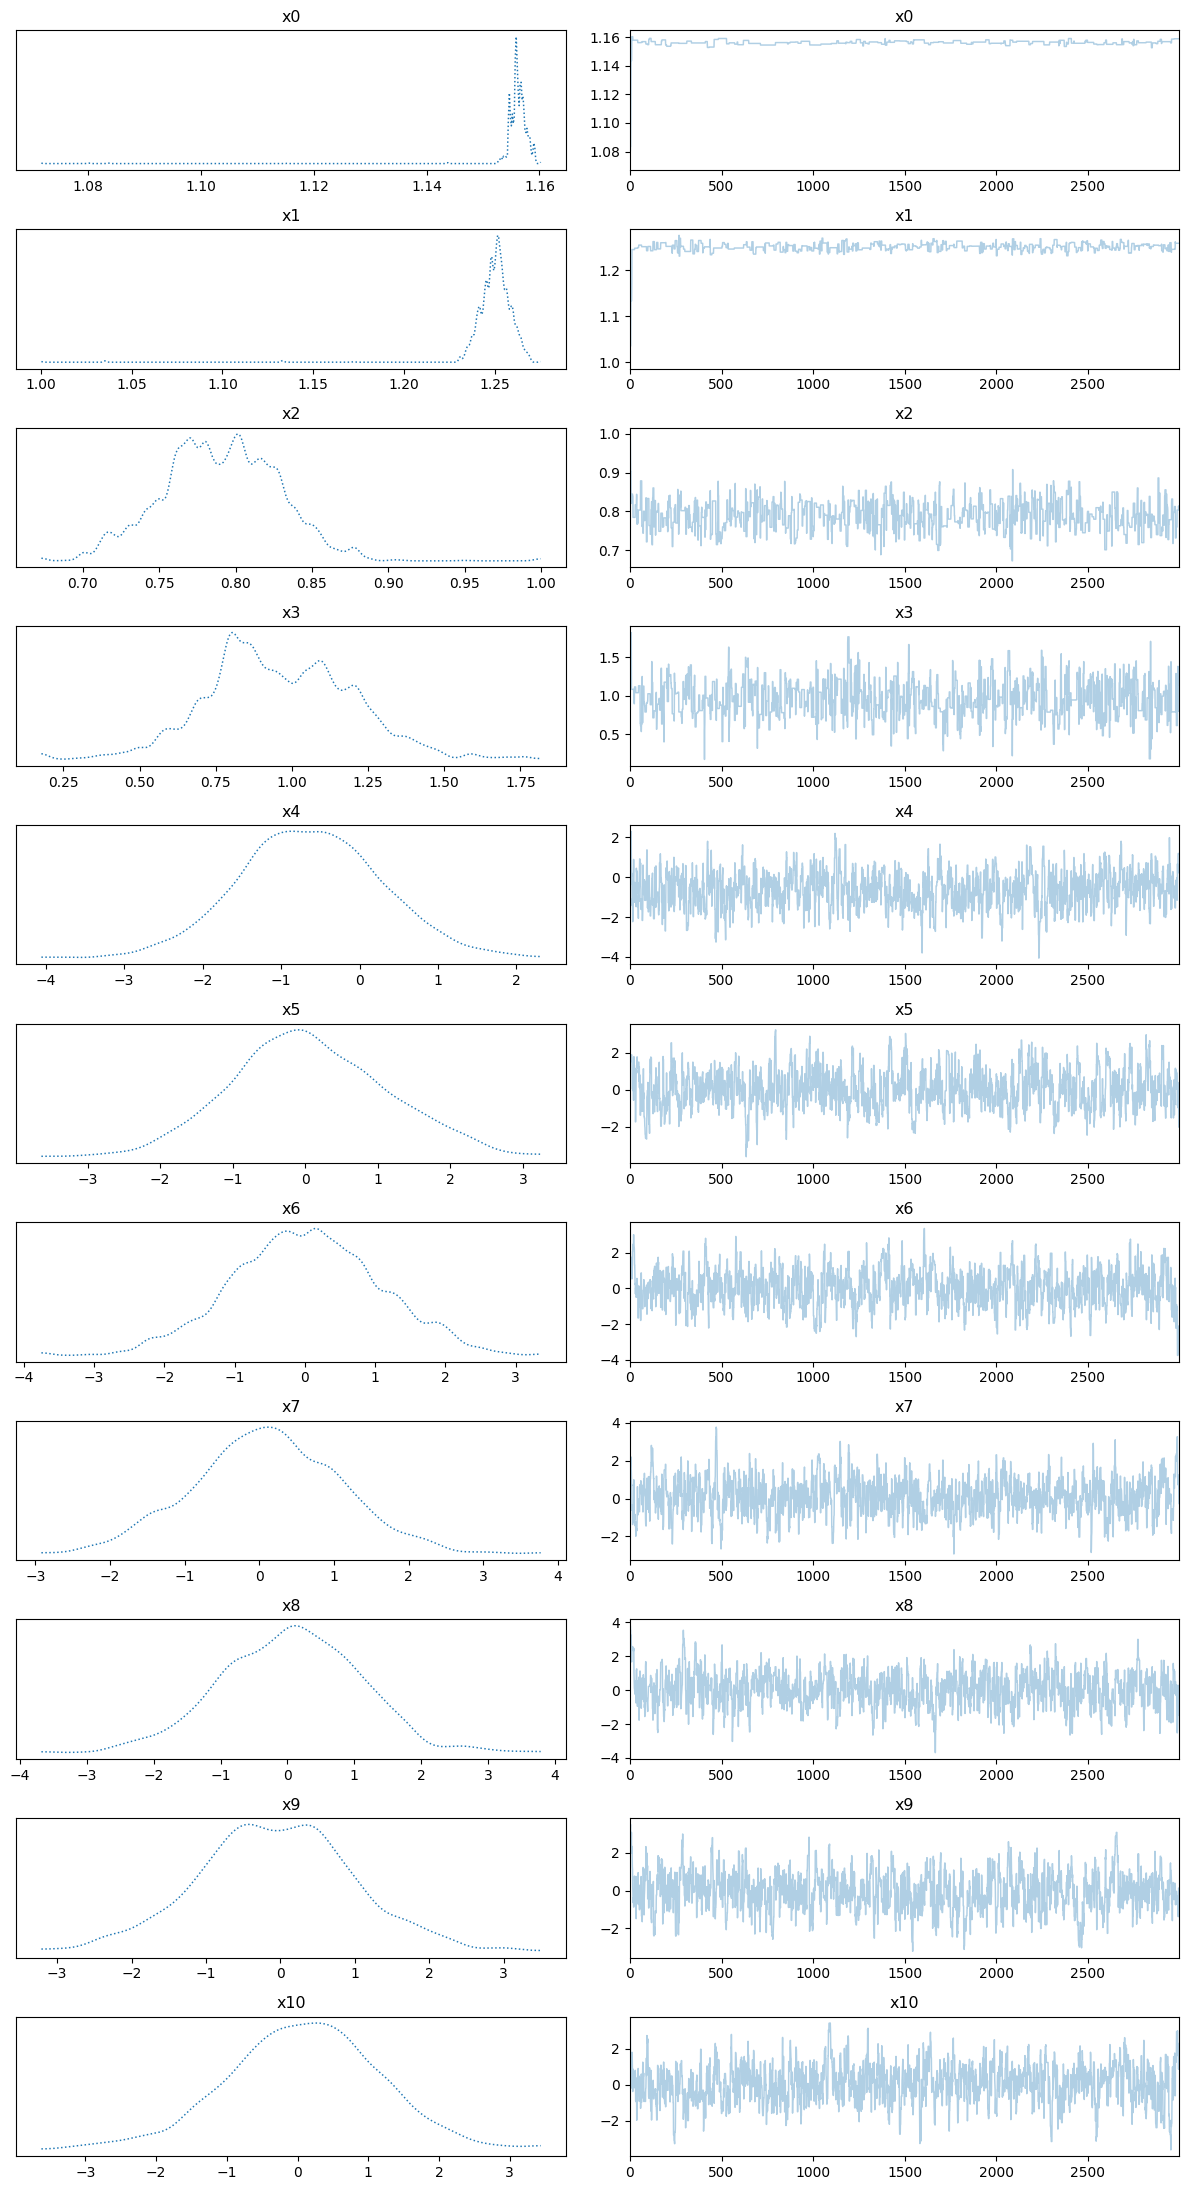

In [54]:
posterior_samples.plot_trace([0,1,2,3,4,5,6,7,8,9,10]);

|

|

|

|

|

|

|

|

|

|


Notes:
* Partial observation 
* Change end point to L
* Enforce positivity 
* Change x to theta
* Fix the noise level
* Try the heavy-side after fixing the noise.
* Combine pCN with CWMH (each good at different modes)
* Reduce the number of nodes
* MAP point 
* hierarchical model for estimating regularity of the heat problem

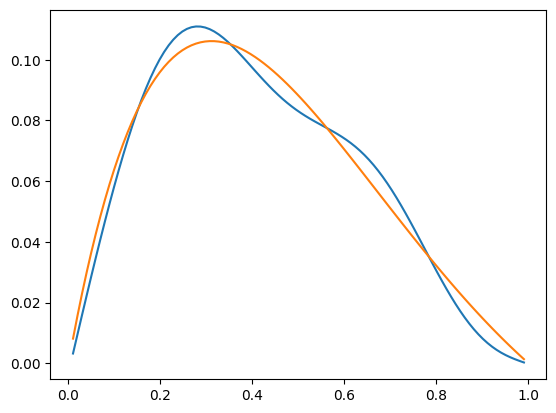

In [55]:
# Compute the MAP point
maximizer = cuqi.solver.maximize(posterior.logpdf, np.zeros(model.domain_dim))
sol = maximizer.solve()
plt.plot(grid, domain_geometry.par2fun(sol[0]))
x_exact.plot()

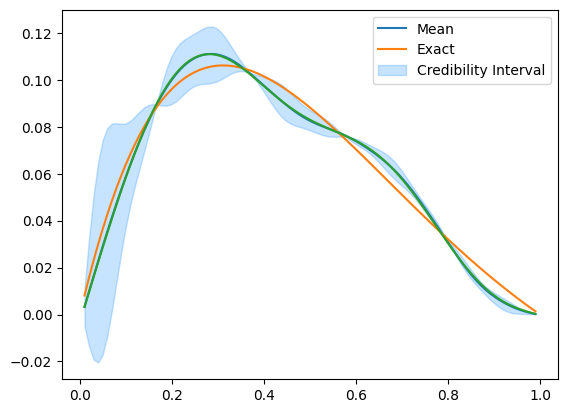

In [56]:
# Plot the posterior ci and MAP point
posterior_samples.plot_ci(95, exact=x_exact)
plt.plot(grid, domain_geometry.par2fun(sol[0]))

In [57]:
# Test that the factor 1/sqrt(N) is required to normalize the error vector.
norms = []
for i in range(100):
    norms.append(np.linalg.norm(np.random.randn(i))/np.sqrt(i))
norms

/var/folders/rr/13wqhtdj7bx5n5j3bfdhsz5r0000gn/T/ipykernel_98597/20277599.py:4: RuntimeWarning: invalid value encountered in double_scalars
  norms.append(np.linalg.norm(np.random.randn(i))/np.sqrt(i))


[nan,
 0.9204484258342178,
 0.7776635587109426,
 0.9887892302798209,
 1.0560723222752395,
 0.8605419896725801,
 0.8523223759026869,
 1.3280188493105902,
 0.9779407022519828,
 0.6291061009301562,
 0.7086923347353767,
 1.4099489278765855,
 1.2052506134946996,
 0.7175272583168032,
 0.9278826687832757,
 0.9448299463415736,
 0.762454559767588,
 0.9132493171959888,
 1.117244296083645,
 0.9817716554489713,
 0.9412727907977064,
 0.9168640187989778,
 1.0737565537605542,
 1.121100062196129,
 1.1655783671285123,
 0.608018792887281,
 0.8008991312365723,
 0.9329102551859542,
 0.930191331479317,
 1.0038128268465272,
 1.2978642422538542,
 1.0886008613930838,
 1.1379048121769049,
 1.1147303255257943,
 0.9139540752698841,
 0.9464056338669968,
 0.9330071044625247,
 1.0273549903825279,
 1.0244616550893673,
 1.0801055858358861,
 1.1023974014495457,
 1.0160195095866797,
 0.9277908001501929,
 0.9727414857779003,
 0.8529357582479914,
 0.9542753847947218,
 0.9219091903470529,
 0.9081066560771185,
 1.071014690

In [58]:
import pickle
pickle.dump(posterior_samples, open('data/'+case_name + '.pkl', 'wb'))